# ResNet50을 fine-tuning하여 암석식별 머신을 만든다.

In [2]:
# 필요한 라이브러리를 임포트한다.

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim

import torchvision
from torchvision import datasets, transforms, models
from PIL import Image

%matplotlib inline


### 이미지 데이터를 ResNet50에 입력하기 위해서 변환한다. (224 x 224)

In [3]:
# 이미지 데이터가 있는 디렉토리와 valid_size를 정한다.

data_dir = './Data'
valid_size = 0.2

# 이미지 데이터를 pytorch에서 다룰 수 있도록 변환시키는 기준을 만든다. -> t_transsform

t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
])

print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    ToTensor()
)


In [4]:
# datasets.ImageFolder를 사용해서 train_data와 test_data를 만든다.

train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

print(train_data)
print(len(train_data), len(test_data))

Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./Data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
155 155


## trainloader와 testloader를 만든다.

In [5]:
# train_data 사이즈만큼의 정수값을 갖는 indices 리스트를 만들고 섞는다.

num_train = len(train_data)
indices = list(range(num_train))
print(indices)

np.random.shuffle(indices)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[135, 1, 120, 30, 86, 98, 134, 144, 41, 69, 6, 137, 60, 95, 96, 107, 46, 85, 93, 104, 114, 128, 17, 101, 34, 147, 145, 92, 56, 100, 126, 76, 18, 33, 15, 25, 47, 84, 80, 8, 52, 94, 97, 146, 62, 148, 38, 73, 31, 121, 0, 51, 9, 64, 42, 91, 102, 32, 113, 10, 53, 29, 44, 75, 28, 63, 79, 89, 88, 136, 127, 71, 74, 106, 141, 119, 58, 118, 2

In [6]:
# 20%를 나타내는 인덱스를 구해서 split에 할당하고 슬라이싱을 사용해서 train_idx와 test_idx를 구한다.

split = int(np.floor(num_train * valid_size))
split

31

In [7]:
#  train_idx와 test_idx를 SubsetRandomSampler에 넘겨주고 각각의 샘플러를 만든다.

train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[76, 18, 33, 15, 25, 47, 84, 80, 8, 52, 94, 97, 146, 62, 148, 38, 73, 31, 121, 0, 51, 9, 64, 42, 91, 102, 32, 113, 10, 53, 29, 44, 75, 28, 63, 79, 89, 88, 136, 127, 71, 74, 106, 141, 119, 58, 118, 23, 19, 45, 82, 4, 13, 117, 133, 3, 78, 111, 39, 35, 49, 151, 112, 43, 27, 50, 122, 12, 131, 103, 149, 21, 138, 48, 130, 20, 55, 22, 81, 65, 109, 59, 139, 142, 110, 153, 83, 108, 26, 14, 99, 24, 7, 2, 67, 5, 129, 16, 125, 143, 36, 40, 54, 77, 37, 115, 70, 154, 116, 132, 87, 68, 105, 124, 11, 57, 66, 140, 90, 61, 150, 123, 72, 152]
[135, 1, 120, 30, 86, 98, 134, 144, 41, 69, 6, 137, 60, 95, 96, 107, 46, 85, 93, 104, 114, 128, 17, 101, 34, 147, 145, 92, 56, 100, 126]


In [8]:
# sampler와 batch_size를 정해서 torch.utils.data.DataLoader를 사용해서 최종 trainloader와 testloader를 만든다.

from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(train_sampler)

trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


In [9]:
# 위의 것을 묶어서 함수 load_split_train_test()를 만든다.

def load_split_train_test(data_dir, valid_size) :
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])
    
    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

In [10]:
# 함수 load_split_train_test()를 함수를 호출하는 부분을 만든다.

trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 함수 load_split_train_test()가 잘 동작하는지 테스트하는 함수 get_random_images를 만든다.

In [11]:
# 함수 load_split_train_test()가 잘 동작하는지를 보는 함수 get_random_images()를 작성해 본다.

num = 5
data = datasets.ImageFolder(data_dir, transform=t_transforms)
print(data)


Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./Data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [12]:
indices = list(range(len(data)))
np.random.shuffle(indices)
print(indices)
idx = indices[:num]

[19, 131, 8, 86, 45, 80, 97, 142, 107, 119, 123, 12, 141, 5, 113, 32, 139, 72, 104, 13, 128, 149, 20, 1, 49, 112, 133, 65, 102, 70, 99, 105, 135, 14, 57, 66, 24, 93, 95, 0, 114, 145, 111, 40, 116, 137, 68, 83, 64, 54, 9, 7, 17, 148, 88, 53, 132, 143, 74, 71, 75, 60, 92, 15, 85, 151, 36, 11, 69, 144, 127, 25, 79, 154, 76, 126, 59, 46, 84, 67, 51, 31, 94, 41, 147, 34, 129, 150, 140, 124, 100, 38, 120, 56, 48, 52, 44, 89, 134, 110, 47, 136, 130, 146, 55, 27, 96, 37, 125, 90, 77, 103, 58, 115, 138, 122, 73, 61, 2, 117, 30, 33, 6, 35, 29, 3, 21, 101, 28, 26, 22, 81, 106, 63, 153, 18, 10, 82, 98, 78, 152, 121, 109, 108, 62, 91, 39, 23, 87, 118, 4, 50, 42, 16, 43]


In [13]:
print(idx)

[19, 131, 8, 86, 45]


In [14]:
sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
print(loader.dataset.classes)

['Basalt', 'Highland']


In [15]:
def get_random_images(num):

    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)

    idx = indices[:num]

    #from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

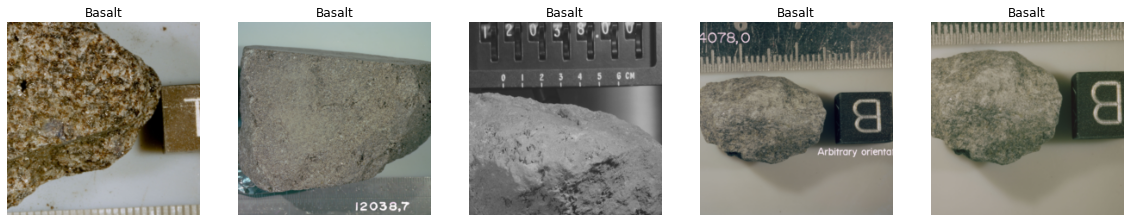

In [16]:
# 임의의 5개의 암석 이미지를 가져와 각각의 암석 종류를 알려주고 이미지를 출력한다.

images, labels = get_random_images(5)

to_pil = transforms.ToPILImage()

fig = plt.figure(figsize=(20, 20))

classes = trainloader.dataset.classes

for ii in range(len(images)) :
    image = to_pil(images[ii])

    sub = fig.add_subplot(1, len(images), ii+1)

    index = labels[ii].item()
    sub.set_title(classes[index])

    plt.axis('off')
    plt.imshow(image)

plt.show()


# ResNet50 모델을 가져와 fc layer를 수정한다.

In [17]:
# device가 CPU인지 GPU인지 정한다.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [18]:
# resnet50 모델을 pretrained=True로 설정해서 가져온다.

model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# 모델의 파라미터를 그대로 사용하고 model.fc layer를 수정한다.
# criterion과 optimizer를 설정한다.
# model을 device에 할당한다. -> done!

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 2),
                            nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

print('done!')


done!


In [20]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)

# 모델을 학습시킨다.

In [21]:
# model을 학습시키기 위한 변수를 설정한다.
# epoch, print_every, running_loss, train_losses, test_losses, step

epochs = 5
print_every = 5
running_loss = 0
train_losses, test_losses = [], []
steps = 0

In [22]:
# for 문을 사용하여 epoch만큼 학습시키고 running_loss를 출력한다.
'''
for epoch in range(epochs) :
    epoch += 1

    for inputs, labels in trainloader:

        steps += 1
        print('Training step ', steps)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        train_losses.append(running_loss/len(trainloader))

    print('epoch : ', epoch)
    print('train_loss : ', running_loss/len(trainloader))
    running_loss = 0
'''

"\nfor epoch in range(epochs) :\n    epoch += 1\n\n    for inputs, labels in trainloader:\n\n        steps += 1\n        print('Training step ', steps)\n\n        inputs, labels = inputs.to(device), labels.to(device)\n\n        optimizer.zero_grad()\n        logps = model.forward(inputs)\n        loss = criterion(logps, labels)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n        train_losses.append(running_loss/len(trainloader))\n\n    print('epoch : ', epoch)\n    print('train_loss : ', running_loss/len(trainloader))\n    running_loss = 0\n"

# 모델을 테스트한다.

In [23]:
# 5번 학습하고 테스트모드로 들어가 테스트한다. 

# for 문을 사용하여 epoch만큼 학습시키고 running_loss를 출력한다.
epochs = 5
print_every = 5
running_loss = 0
train_losses, test_losses = [], []
steps = 0


for epoch in range(epochs) :
    epoch += 1

    for inputs, labels in trainloader:

        steps += 1
        print('Training step ', steps)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:

            test_loss = 0
            accuracy = 0

            model.eval()

            with torch.no_grad():

                for inputs, labels in testloader:

                    inputs, labels = inputs.to(device), labels.to(device)

                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print('\n   Epoch : ', epoch, '/', epochs)
            print('train_loss : ', running_loss/len(trainloader))
            print('test_loss : ',test_loss/len(testloader))
            print('test accuracy : ', accuracy/len(testloader), '\n')

            running_loss = 0
            model.train()
            break
        


Training step  1
Training step  2
Training step  3
Training step  4
Training step  5

   Epoch :  1 / 5
train_loss :  1.49513728171587
test_loss :  0.6658402979373932
test accuracy :  0.5541666746139526 

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10

   Epoch :  2 / 5
train_loss :  0.8693271167576313
test_loss :  1.8802844285964966
test accuracy :  0.5208333432674408 

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15

   Epoch :  3 / 5
train_loss :  0.6470361649990082
test_loss :  0.664318859577179
test accuracy :  0.612500011920929 

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20

   Epoch :  4 / 5
train_loss :  0.37193726748228073
test_loss :  0.6201501786708832
test accuracy :  0.7104166746139526 

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25

   Epoch :  5 / 5
train_loss :  0.2686215918511152
test_loss :  0.2975012

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# 학습과 테스트가 완료된 모델을 저장한다.

torch.save(model, 'aerialmodel.pth')

# 모델을 사용하여 예측한다.

In [26]:
# 함수 predict_image()를 작성한다.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('aerialmodel.pth')

In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# get_random_images()를 사용하여 임의의 5개 암석 이미지를 가져와서 예측해본다.

def predict_image(image):

    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

In [29]:
trainloader.dataset.classes

['Basalt', 'Highland']

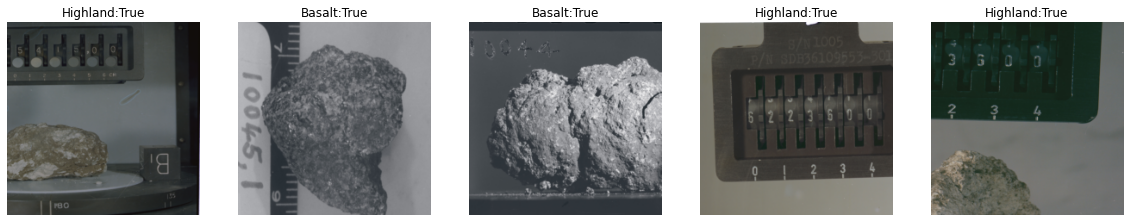

In [31]:
model.eval()

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)

fig = plt.figure(figsize=(20, 10))

classes = trainloader.dataset.classes

for ii in range(len(images)):

    image = to_pil(images[ii])
    index = predict_image(image)

    sub = fig.add_subplot(1, len(images), ii+1)

    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))

    plt.axis('off')
    plt.imshow(image)

plt.show()
